In [1]:
!pip uninstall opencv-python-headless==4.5.3.56 --yes


In [2]:
# WandB – Install the W&B library
!pip install wandb -q
!pip install opencv-python==4.1.2.30
!pip install imageio
!pip install onnxruntime
!pip install keras2onnx
!pip install tf2onnx
!pip install pyyaml h5py


     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 144 kB 24.0 MB/s 
     |████████████████████████████████| 181 kB 36.1 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 5.2 MB 5.4 MB/s 
     |████████████████████████████████| 96 kB 3.0 MB/s 
     |████████████████████████████████| 12.8 MB 32.9 MB/s 
     |████████████████████████████████| 87 kB 6.5 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=80910d4ca9168e63380150ae17fe096123e8039cf6e7c4b76597ae1f2e4ccac8
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
     |████████████████████████████████| 435 kB 5.3 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalle

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

import wandb
from wandb.keras import WandbCallback
wandb.login()

import tf2onnx
import onnx

import imageio, glob, cv2
import matplotlib.pyplot as plt
%matplotlib inline

2022-04-17 13:50:09.389060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 13:50:09.389136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michaelazarzar (use `wandb login --relogin` to force relogin)


In [2]:
(train_images, train_labels),(test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Plot head of dataset

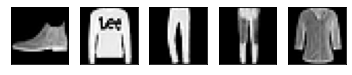

In [4]:
# summarize loaded dataset
# plot first few images
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# Save images for API test

In [5]:
images_to_save = test_images[:5] 
labels_to_save = test_labels[:5]

In [6]:
for i in range(len(images_to_save)):
    plt.imsave('images/image_' + str(i) + '.png', images_to_save[i], cmap = 'gray')


# Remove saved images from test

In [7]:
test_images = test_images[5:]
test_labels = test_labels[5:]

# Prepare data for model

In [8]:
# Reshape and normalize images.
train_images_re = np.expand_dims(train_images, axis=3) 
test_images_re = np.expand_dims(test_images, axis=3) 

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

classes = np.unique(train_labels)
input_shape = train_images_re[0].shape

print(classes)
print(input_shape)


[0 1 2 3 4 5 6 7 8 9]
(28, 28, 1)


# Images and Lables

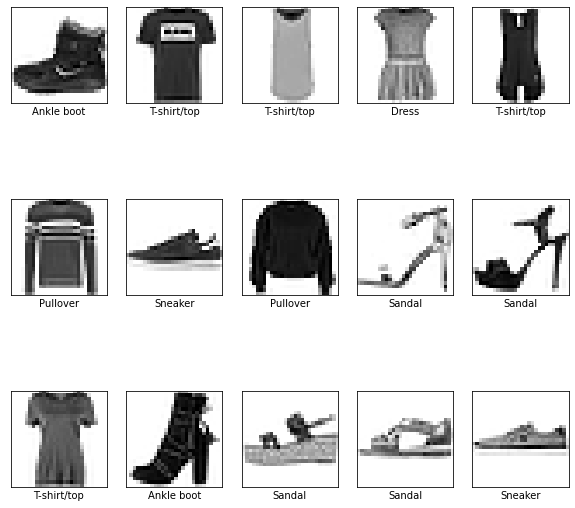

In [9]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images_re[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Set W&B

In [24]:
# Initilize a new wandb run
wandb.init(project="AICourseFashioMnist-AviAndMichael")

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = 0.05
config.epochs = 10
config.img_width=28
config.img_height=28
config.num_classes = 10
config.batch_size = 256
config.validation_split = 0.2
config.weight_decay = 0.0005
config.activation = 'relu'
config.optimizer = 'Adam'
config.seed = 10

wandb: Currently logged in as: michaelazarzar (use `wandb login --relogin` to force relogin)


# CreateModels

In [11]:

def createModel(input_shape, num_classes):
    model = Sequential([keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")])
    return model


In [25]:
model = createModel(input_shape, len(classes))


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                  

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



# Train model

In [28]:
%%wandb
history = model.fit(
    train_images_re,                 
    train_labels, 
    epochs=config.epochs, 
    steps_per_epoch=len(train_images_re) / 32,
    shuffle=True,
    validation_split = 0.2,
    verbose = 0,
    callbacks=[
        WandbCallback(),
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [29]:
test_loss, test_acc = model.evaluate(test_images_re,  test_labels, verbose=1)

  8/313 [..............................] - ETA: 2s - loss: 0.2507 - accuracy: 0.9297  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 [==============================] - 2s 7ms/step - loss: 0.2933 - accuracy: 0.8966


# PLOT history

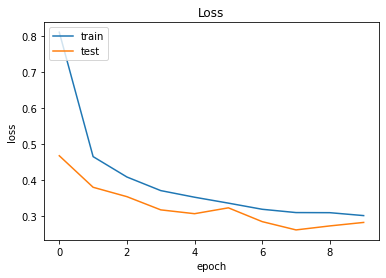

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save model to .onnx format

In [33]:

onnx_model, _ = tf2onnx.convert.from_keras(model,
                                           #input_sig,
                                           opset=13)

onnx.save(onnx_model, 'models/model.onnx')

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [34]:
model.save('models/single_run_model.h5')

In [35]:
model1 = keras.models.load_model('models/single_run_model.h5')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                  